Iterative SLS example with nonlinear dynamics for the state [joint_pos, joint_vel, end_pos, end_vel] and the control [joint_acc] with a quadratic cost.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import block_diag
from copy import deepcopy
from time import time
import matplotlib.patches as mpatches
from time import sleep
import os

import pinocchio as pin
from isls import iSLS
from isls.utils import get_double_integrator_AB, plot_robot, plot_robot_base
from isls.projections import *

%matplotlib inline
%load_ext autoreload
%autoreload 2
plt.style.use("default")
plt.rcParams['font.size'] = 13
plt.rcParams['axes.linewidth'] = 1.5
np.set_printoptions(precision=5, suppress=False)
plt.rcParams["figure.figsize"] = (4,3)
real_min = np.finfo(float).tiny

### Problem setup in Pinocchio

In [2]:
# Load the urdf model
urdf_path = '/urdfs/3dof_robot.urdf'
model = pin.buildModelFromUrdf(os.getcwd() + urdf_path)
print('model name: ' + model.name)
# Create data required by the algorithms
data     = model.createData()
frame_names = ["base", "link1", "link2", "link3", "ee"]
ids = []
for name in frame_names:
    ids += [model.getFrameId(name)]

model name: 3dof


#### Functions for forward kinematics, jacobian and poses of each frame for plotting.

In [11]:
ee = ids[-1]
def pin_fk(q):
    if q.ndim == 1:
        pin.forwardKinematics(model,data,q)
        pin.updateFramePlacements(model,data)
        return data.oMf[ee].translation
    else:
        batch_size = q.shape[0] 
        xs_log = np.zeros((batch_size,x_dim))
        for i in range(batch_size):
            # Perform the forward kinematics over the kinematic tree
            pin.forwardKinematics(model,data,q[i])
            pin.updateFramePlacements(model,data)
            # Print out the placement of each joint of the kinematic tree
            xs_log[i] = data.oMf[ee].translation
        return xs_log
    
def pin_jacobian(q):
    batch_size = q.shape[0] if q.ndim == 2 else 1
    if batch_size == 1:
        return pin.computeFrameJacobian(model,data,q,ee, pin.LOCAL_WORLD_ALIGNED)[:x_dim]
    else:
        J_log = np.zeros((batch_size,x_dim,q_dim))
        for i in range(batch_size):
            J_log[i] = pin.computeFrameJacobian(model,data,q[i],ee, pin.LOCAL_WORLD_ALIGNED)[:x_dim]
        return J_log[:,:x_dim]
    
def xs2plot(q):
    xs = np.zeros((q.shape[0], len(frame_names), x_dim))
    for k,q_ in enumerate(q):
        pin.forwardKinematics(model,data,q_)
        pin.updateFramePlacements(model,data)
        for i,id_ in enumerate(ids):
            xs[k,i] =  data.oMf[id_].translation
    return xs[:,:,:2]

### Problem parameters 

In [612]:
q_dim = 3
x_dim = 3
state_dim = q_dim*2 + x_dim  #[q, dq, x]
u_dim = q_dim # [ddq]
T = 1.
horizon = 100
N = horizon
dt = T/N
print("dt:", dt)
d= state_dim
sls = iSLS(d, u_dim, N)

dt: 0.01


#### Forward model f(x, u) and its jacobian get_AB(x, u)

In [613]:
def f(x, u):
    q     = x[..., :q_dim]
    q_dot = x[..., q_dim:q_dim*2]
    x     = x[..., q_dim*2:]
    
    q     = q + q_dot*dt + 0.5*u*(dt**2)
    q_dot = q_dot + u*dt
    x     = pin_fk(q)
    return np.concatenate([q, q_dot, x],-1) 
# Set the forward model
sls.forward_model = f

In [614]:
A_, B_ = get_double_integrator_AB(q_dim, nb_deriv=2, dt=dt)
A = np.zeros((N, d, d))
B = np.zeros((N, d, u_dim))
A[:,:q_dim*2, :q_dim*2] = A_
B[:,:q_dim*2] = B_
def get_AB(x, u):
    q     = x[..., :q_dim]
    q_dot = x[..., q_dim:q_dim*2]
    J = pin_jacobian(q + q_dot*dt + 0.5*u*(dt**2))
    
    A[:,q_dim*2:, :q_dim] = J
    A[:,q_dim*2:, q_dim:q_dim*2] = J*dt
    
    B[:,q_dim*2:] = 0.5*J*(dt**2)
    return A,B

#### Task definition

In [628]:
# state = [q (3), q_dot (3), x (3), x_dot (3) ], x = [x,y,z]
final_pos = [1.5, 2., 0]
x_std = 1e3
u_std = 1e-4


x_final_target = np.concatenate([[0]*q_dim, [0]*q_dim, final_pos],-1)
viaQ_final = block_diag(*[np.diag([0]*q_dim + [x_std]*q_dim + [x_std] + [x_std] + [0])])


free_state = np.concatenate([np.zeros(q_dim*2+x_dim)], -1)
viaQ_free = block_diag(*[np.diag([0]*q_dim + [0]*q_dim + [0]*x_dim)])

zs = np.stack([free_state, x_final_target])
Qs = np.stack([viaQ_free, viaQ_final])


seq = np.zeros(N, dtype=np.int32)
seq[-1] = 1

In [629]:
# Set the cost variables if quadratic cost
sls.set_cost_variables(zs, Qs, seq, u_std)

### Solve the unconstrained problem

In [692]:
# initial guess
u0 = np.ones((N,u_dim))*0.
q0 = np.array([ np.pi/3,-np.pi/2,-np.pi/4])*0
q0 = np.array([ np.pi/3,-np.pi/2,-np.pi/4])
x0 = np.array(q0.tolist()+[0]*q_dim+pin_fk(q0).tolist())

x_nom,u_nom = sls.rollout_batch(x0[None], u0[None])
x_nom = x_nom[0]
u_nom = u_nom[0]

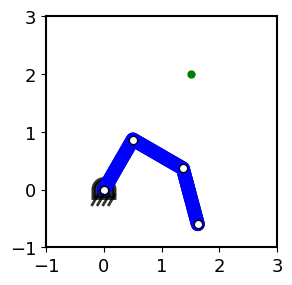

In [693]:
sls.reset() # reset if you reinitialize the problem
sls.nominal_values = x_nom, u_nom


fig,ax = plt.subplots(ncols=1, figsize=(6,3))
xlim = [-1,3]
ylim = [-1,3]
xs_plot = xs2plot(sls.x_nom[:,:q_dim])

plot_robot(xs_plot[0],ax=ax, xlim=xlim, ylim=ylim)

for k in range(1,N):
    if not k%10:
        plot_robot(xs_plot[k],color="b",alpha=0.1,ax=ax)
plot_robot(xs_plot[-1],color="b",alpha=1,ax=ax, robot_base=True)
ax.plot(final_pos[0], final_pos[1],"go", ms=5, label="goal")


In [694]:
# Reset the model
sls.reset()
# Initialize the model
sls.nominal_values = x_nom, u_nom
# Set to true to solve with dynamic programming, otherwise uses least square in batch form
dp = True

In [695]:
%%time
# Solve
sls.solve_ilqr(get_AB, max_ilqr_iter=30, max_line_search_iter=20, dp=dp)
print(sls.cost_log)

Cost change is too low, cannot improve anymore at iteration 6 .
[6775.068343357641, 2548.038311987151, 325.4571804230292, 9.27551108903625, 0.13299337527534424, 0.11808042130251896, 0.1180803005667605]
Wall time: 131 ms


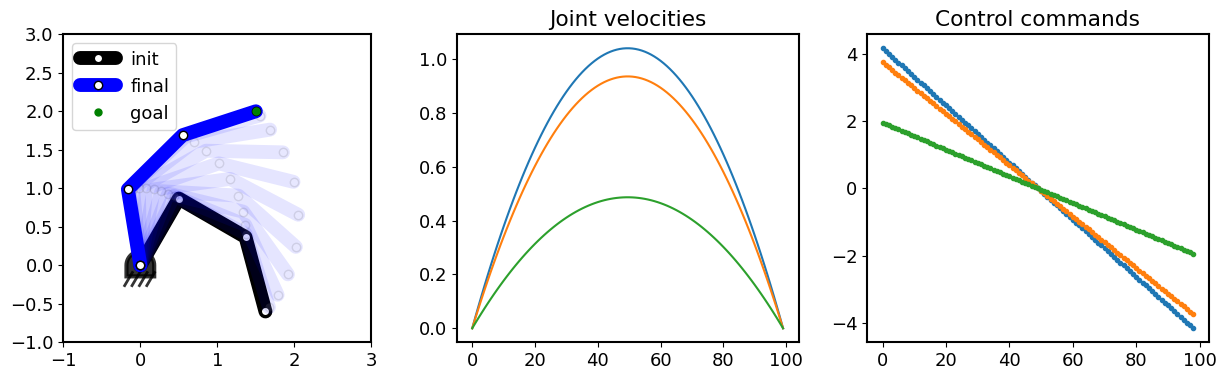

In [696]:
fig,ax= plt.subplots(ncols=3,figsize=(15,4))

ax[2].plot(sls.u_nom[:-1,:],".")
ax[2].set_title("Control commands")

ax[1].plot(sls.x_nom[:,3:6])
ax[1].set_title("Joint velocities")


xlim = [-1,3]
ylim = [-1,3]
xs_plot = xs2plot(sls.x_nom[:,:q_dim])
plot_robot(xs_plot[0],ax=ax[0], xlim=xlim, ylim=ylim, label="init", robot_base=True)

for k in range(1,N):
    if not k%10:
        plot_robot(xs_plot[k],color="b",alpha=0.1,ax=ax[0])
plot_robot(xs_plot[-1],color="b",alpha=1,ax=ax[0], label="final")
ax[0].plot(final_pos[0], final_pos[1],"go", ms=5, label="goal")
ax[0].legend()

## Solve the constrained problem

In [727]:
var_x0 = 0.1
noise_scale = 0.0
scale_x0 = np.sqrt(var_x0)
nb_experiments = 1000

x_logs = np.zeros((2, nb_experiments, N,  d))
u_logs = np.zeros((2, nb_experiments, N,  u_dim))
x0s = np.tile(sls.x_nom[0:1], (nb_experiments,1))
x0s[:, :q_dim] = np.random.normal(loc=sls.x_nom[0,:q_dim], scale=scale_x0, size=(nb_experiments, q_dim))

### Define constraints

In [728]:
## Solve bound constrained problem for the comparison 
# (in this case no bound constraint required as the optimal solution is already inside bounds)
sls.reset()
sls.nominal_values = x_nom, u_nom
du, phi_u = sls.isls_admm(q_dim, get_AB, max_line_search=10,k_max=100, max_admm_iter=10, 
                      threshold=1e-4, verbose=True, log=True)
PHI_U = np.zeros((u_dim*N, d*N))
PHI_U[:,:q_dim] = phi_u
K_sls_unc, k_sls_unc = sls.controller(PHI_U, du)
x_logs[0], u_logs[0] = sls.get_trajectory_sls(x0s, K_sls_unc, k_sls_unc, noise_scale=noise_scale)
print(sls.cost_log)

ADMM converged at iteration  0 !
ADMM residual is  0.00e+00 0.00e+00
Iteration number  0 iSLS cost:  2548.038311983808
ADMM converged at iteration  0 !
ADMM residual is  0.00e+00 0.00e+00
Iteration number  1 iSLS cost:  325.457180414432
ADMM converged at iteration  0 !
ADMM residual is  0.00e+00 0.00e+00
Iteration number  2 iSLS cost:  9.275511088978202
ADMM converged at iteration  0 !
ADMM residual is  0.00e+00 0.00e+00


C:\Users\hakan\anaconda3\envs\hg\lib\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hakan\anaconda3\envs\hg\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Iteration number  3 iSLS cost:  0.13299337527657626
ADMM converged at iteration  0 !
ADMM residual is  0.00e+00 0.00e+00
Iteration number  4 iSLS cost:  0.1180804213025188
ADMM converged at iteration  0 !
ADMM residual is  0.00e+00 0.00e+00
Iteration number  5 iSLS cost:  0.11808030056676026
Cost change is too low, cannot improve anymore at iteration 5 .
[6775.068343357641, 2548.038311983808, 325.457180414432, 9.275511088978202, 0.13299337527657626, 0.1180804213025188, 0.11808030056676026]


In [732]:
### Control limits & robustness against a change in the initial configuration of the robot.
lower_u = -6.
upper_u = 6.
from scipy.stats import norm

# For robust constraints only for x0's position, z has dim 1+x_dim
mu = np.zeros(1 + q_dim) # [1, delta_x0]
mu[0] = 1. 

sigma = np.zeros(q_dim + 1)
sigma[0] = 0. # first term is deterministic and equal to one.
sigma[1:] = var_x0 # variance for the x0
psi_inv = norm.ppf(0.82)
# psi_inv = norm.ppf(0.5)+1e-100 # should be the same as expected
 
Au = np.diag(np.sqrt(sigma))
bu = np.zeros(Au.shape[0])
cu = -mu/psi_inv

Al = Au
bl = bu
cl = mu/psi_inv

As = [Au, Al]
bs = [bu, bl]
cs = [cu, cl]
ds = [du, dl]

nb_proj = 2 # nb of projections needed for each row of psi_u

A_ = [np.concatenate([As[i] ,cs[i][None]], axis=0) for i in range(nb_proj)]


In [733]:
# Problem parameters
def project_u(u, u_nom):
    u_nom_ = u_nom.flatten()
    y_ = u.copy()
    y_[:,0] += u_nom_
    y_ =  project_set_convex(y_, A_, b_, projections=[project_soc_unit]*nb_proj,rho=1e1, max_iter=100, threshold=1e-4, verbose=0)
    y_[:,0] -= u_nom_
    return y_

In [734]:
%%time
rho_u = 1e0
sls.reset()

# initial guess
# u0 = np.random.normal(size=(N,u_dim))*0.1
u0 = np.ones((N,u_dim))*0.
# q0 = np.array([ np.pi/3,-np.pi/2,-np.pi/4])*0
q0 = np.array([ np.pi/3,-np.pi/2,-np.pi/4])
x0 = np.array(q0.tolist()+[0]*q_dim+pin_fk(q0).tolist())

x_nom,u_nom = sls.rollout_batch(x0[None], u0[None])
x_nom = x_nom[0]
u_nom = u_nom[0]
sls.nominal_values = x_nom, u_nom

du, phi_u = sls.isls_admm(q_dim, get_AB, max_line_search=30,k_max=50, project_u=project_u, rho_u=rho_u, max_admm_iter=10, 
                      threshold=1e-4, verbose=0, log=True)
PHI_U = np.zeros((u_dim*N, d*N))
PHI_U[:,:q_dim] = phi_u
K_sls, k_sls = sls.controller(PHI_U, du)
x_logs[1], u_logs[1] = sls.get_trajectory_sls(x0s, K_sls, k_sls, noise_scale=noise_scale)
print(sls.cost_log)
thr = 1e-3
names = ["DP", "SLS"]
for i in range(2):
    su = np.all(lower_u - thr <= u_logs[i,:,:,:], axis=(1,2))
    su = su * np.all(u_logs[i,:,:,:] <= upper_u + thr, axis=(1,2))
    print("Percentage of success for", names[i], 100*np.sum(su)/nb_experiments)

Iteration number  0 iSLS cost:  1669.2494696317226
Iteration number  1 iSLS cost:  189.7022303476113
Iteration number  2 iSLS cost:  2.421830366840616
Iteration number  3 iSLS cost:  0.17808504382655083
Iteration number  4 iSLS cost:  0.17552717658976105
Iteration number  5 iSLS cost:  0.17541393096016222
Iteration number  6 iSLS cost:  0.17518608327331026
Iteration number  7 iSLS cost:  0.17484468856462562
Iteration number  8 iSLS cost:  0.17439121780794895
Iteration number  9 iSLS cost:  0.17382760019114807
Iteration number  10 iSLS cost:  0.17315620283307617
Iteration number  11 iSLS cost:  0.17237982036648286
Iteration number  12 iSLS cost:  0.1715016628682166
Iteration number  13 iSLS cost:  0.17052534213473275
Iteration number  14 iSLS cost:  0.16945485637672927
Iteration number  15 iSLS cost:  0.16829457339579143
Iteration number  16 iSLS cost:  0.16704921231197442
Iteration number  17 iSLS cost:  0.16572382391872012
Iteration number  18 iSLS cost:  0.16432376974690271
Iteration

Text(0.5, 0, '$t$')

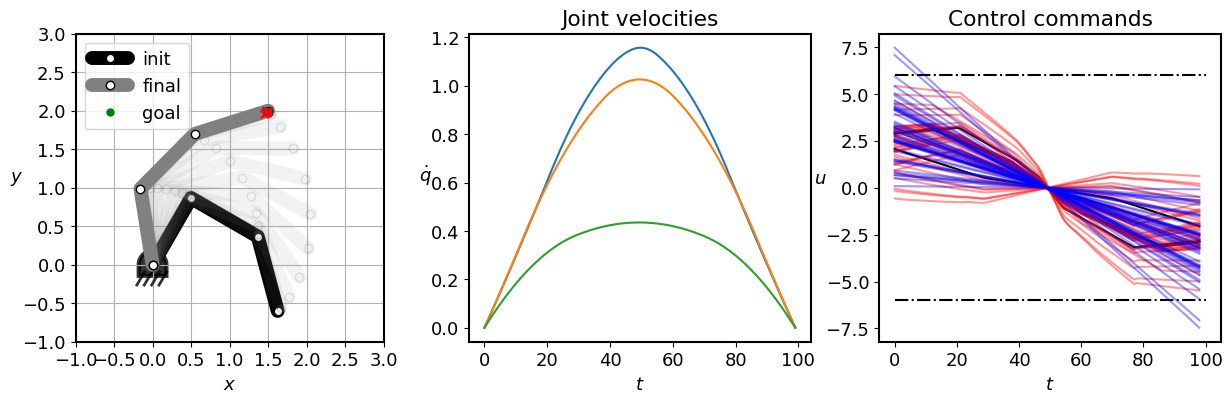

In [737]:
plt.close("all")
fig,ax= plt.subplots(ncols=3,figsize=(15,4))

# Plot of experiments:
nb_show_exp = 15
ax[0].plot(x_logs[1][:nb_show_exp,-1,-3], x_logs[1][:nb_show_exp,-1,-2], "rx", zorder=10)
[ax[2].plot(u_logs[1][i,:-1,:], "r", zorder=10, alpha=0.4) for i in range(nb_show_exp)]

ax[0].plot(x_logs[0][:nb_show_exp,-1,-3], x_logs[0][:nb_show_exp,-1,-2], "x", color="blue", zorder=9)
[ax[2].plot(u_logs[0][i,:-1,:], "b", zorder=10, alpha=0.4) for i in range(nb_show_exp)]


# Plot of nominal solution
ax[2].plot(sls.u_nom[:-1,:],"k-")
ax[2].plot(np.linspace(0,N,10),[upper_u]*10, "-.",color="k")
ax[2].plot(np.linspace(0,N,10),[lower_u]*10, "-.",color="k")

ax[2].set_title("Control commands")


ax[1].plot(sls.x_nom[:,3:6])
ax[1].set_title("Joint velocities")


xlim = [-1,3]
ylim = [-1,3]
xs_plot = xs2plot(sls.x_nom[:,:q_dim])

plot_robot(xs_plot[0],ax=ax[0], color="k", xlim=xlim, ylim=ylim, label="init", robot_base=True)

for k in range(1,N):
    if not k%10:
        plot_robot(xs_plot[k],color="gray",alpha=0.1,ax=ax[0],)
plot_robot(xs_plot[-1],alpha=1.,color="gray", ax=ax[0], label="final")

ax[0].plot(final_pos[0], final_pos[1],"go", ms=5, label="goal")

ax[0].legend()

ax[0].grid()
ax[0].set_xticks(np.linspace(xlim[0], xlim[1], 9))


ax[0].set_ylabel(r"$y$", rotation=0)
ax[0].set_xlabel(r"$x$")

ax[1].set_ylabel(r"$\dot{q}$", rotation=0)
ax[1].set_xlabel(r"$t$")

ax[2].set_ylabel(r"$u$", rotation=0)
ax[2].set_xlabel(r"$t$")